In [25]:
%env TF_FORCE_UNIFIED_MEMORY=1

env: TF_FORCE_UNIFIED_MEMORY=1


In [56]:
import unlimtd_f
import time
from jax import random, jit, pmap, value_and_grad, lax
import dataset_multi_infinite
import test
import plots
import ntk
import nll
import jax
from jax import numpy as np
import pickle
import models
import utils

In [57]:
seed = 1655235988902897757
print(seed)

1655235988902897757


In [58]:
def nll(kernel_self, part_apply_fn, x_a, y_a, maddox_noise):
    """
    Computes the NLL of this data (one task only) wrt the kernel
    x_a is a (batch_size, input_dims) array (! has lost n_tasks)
    y_a is a (batch_size, reg_dim) array (! has lost n_tasks)
    """
    cov_a_a = kernel_self(x_a)
    K = cov_a_a.shape[0]
    cov_a_a = cov_a_a + maddox_noise ** 2 * np.eye(K)
    
    # prior mean is 0
    y_a = np.reshape(y_a, (-1))

    L = jax.scipy.linalg.cho_factor(cov_a_a)
    ypred_a = np.reshape(part_apply_fn(inputs = x_a), (-1,))
    alpha = jax.scipy.linalg.cho_solve(L, y_a - ypred_a)
    return 0.5 * (y_a - ypred_a).T @ alpha + np.sum(np.log(np.diag(L[0]))) + 0.5 * K * np.log(2 * np.pi)


In [59]:
def nll_batch_one_kernel(kernel_self, part_apply_fn, x_a, y_a, maddox_noise, jacobian, mean):
    """
    NLL for a batch of tasks, when there is only one kernel (singGP)
    x_a is (n_tasks, batch_size, input_dims) (input_dims are (128, 128, 1) for vision, (1,) for toy problems)
    y_a is (n_tasks, batch_size, reg_dim)
    """
    def f(carry, task_data):
        x_a, y_a = task_data
        y_a = y_a - utils.falseaffine_correction0(jacobian, mean, x_a)
        loss_here = nll(kernel_self, part_apply_fn, x_a, y_a, maddox_noise)
        return None, loss_here

    _, losses = lax.scan(f, None, (x_a, y_a))

    return np.array(losses)

In [60]:
from functools import partial

def nll_batch_average_identity_cov(current_params, current_mean, apply_fn, current_batch_stats, x_a, y_a, maddox_noise):
    _, kernel_self, jacobian = get_kernel_and_jac_identity_cov(apply_fn, current_params, current_batch_stats)
    part_apply_fn = (partial(apply_fn, current_params, current_batch_stats))
    
    return np.mean(nll_batch_one_kernel(kernel_self, part_apply_fn, x_a, y_a, maddox_noise, jacobian, current_mean))

In [61]:
def pmapable_loss_identity_cov(current_state, x_a, y_a, maddox_noise):
    # we can't pass current_state because we have to explicitely show the variable
    loss, (gradients_p, gradients_m) = value_and_grad(nll_batch_average_identity_cov, argnums = (0, 1) )(current_state.params,
                                                              current_state.mean,
                                                              current_state.apply_fn,
                                                              current_state.batch_stats,
                                                              x_a,
                                                              y_a,
                                                              maddox_noise)
    
    return loss, (gradients_p, gradients_m)

In [62]:
@jit
def batch_stats_updater(current_state, x_a):
    # shape of x_a is (n_tasks, batch_size, inputs_dims...)
    
    batch_stats = current_state.batch_stats
    
    def f(old_batch_stats, _x_a):
        # shape of _x_a is (batch_size, input_dims)
        _, mutated_vars = current_state.apply_fn_raw({"params":current_state.params,
                                                      "batch_stats": old_batch_stats},
                                                     _x_a,
                                                     mutable=["batch_stats"])
        
        new_batch_stats = mutated_vars["batch_stats"]
        return new_batch_stats, None

    batch_stats = dict(batch_stats)
    print(type(batch_stats))
    batch_stats, _ = lax.scan(f, batch_stats, x_a)
    return batch_stats

In [63]:
@jit
def grad_applier_identity_cov(current_state, gradients_p, gradients_m, new_batch_stats):
    return current_state.apply_gradients(grads_params=gradients_p, grads_mean=gradients_m, new_batch_stats=new_batch_stats)

In [64]:
def step_identity_cov(key, current_state, n_tasks, K, data_noise, maddox_noise, n_devices, get_train_batch_fn):
    # Draw the samples for this step, and split it to prepare for pmap (jit'd)
    x_a, y_a, x_a_div, y_a_div = get_train_batch_fn(key, n_tasks, K, data_noise, n_devices)
    
    # Compute loss and gradient through gpu parallelization
    unaveraged_losses, (unaveraged_gradients_p, unaveraged_gradients_m) = pmap(pmapable_loss_identity_cov,
                             in_axes=(None, 0, 0, None),
                             static_broadcasted_argnums=(3)
                            )(current_state, x_a_div, y_a_div, maddox_noise)
    
    current_loss = np.mean(unaveraged_losses)
    current_gradients_p = jax.tree_map(lambda array: np.mean(array, axis=0), unaveraged_gradients_p)
    current_gradients_m = jax.tree_map(lambda array: np.mean(array, axis=0), unaveraged_gradients_m)
    
    # Update batch_stats "manually" (jit'd)
    new_batch_stats = batch_stats_updater(current_state, x_a)
    
    # Update state (parameters and optimizer)
    current_state = grad_applier_identity_cov(current_state, current_gradients_p, current_gradients_m, new_batch_stats)
    
    return current_state, current_loss

## Unlimitd f training

In [115]:
def nll_logaddexp(nll1, nll2):
    return np.log(2) - np.logaddexp(-nll1, -nll2)

In [116]:
def nll_batch_two_kernels(kernel_self1, kernel_self2, part_apply_fn, x_a, y_a, maddox_noise, jacobian1, jacobian2, mean1, mean2):
    """
    NLL for a batch of tasks, when there are two kernels (mixture of GPs)
    x_a is (n_tasks, batch_size, input_dims) (input_dims are (128, 128, 1) for vision, (1,) for toy problems)
    y_a is (n_tasks, batch_size, reg_dim)
    """
    def f(carry, task_data):
        x_a, y_a = task_data
        y_a1 = y_a - utils.falseaffine_correction0(jacobian1, mean1, x_a)
        y_a2 = y_a - utils.falseaffine_correction0(jacobian2, mean2, x_a)
        loss_1 = nll(kernel_self1, part_apply_fn, x_a, y_a1, maddox_noise)
        loss_2 = nll(kernel_self2, part_apply_fn, x_a, y_a2, maddox_noise)
        return None, nll_logaddexp(loss_1, loss_2)

    _, losses = lax.scan(f, None, (x_a, y_a))

    return np.array(losses)

In [117]:
def nll_batch_average_lowdim_cov_mixture(current_params, current_mean1, current_mean2, current_scale1, current_scale2, apply_fn, current_batch_stats, proj1, proj2, x_a, y_a, maddox_noise):
    _, kernel_self1, jacobian1 = get_kernel_and_jac_lowdim_cov(apply_fn, current_params, current_scale1, current_batch_stats, proj1)
    _, kernel_self2, jacobian2 = get_kernel_and_jac_lowdim_cov(apply_fn, current_params, current_scale2, current_batch_stats, proj2)

    part_apply_fn = (partial(apply_fn, current_params, current_batch_stats))
    return np.mean(nll_batch_two_kernels(kernel_self1, kernel_self2, part_apply_fn, x_a, y_a, maddox_noise, jacobian1, jacobian2, current_mean1, current_mean2))

In [118]:
def pmapable_loss_lowdim_cov_mixture(current_state, x_a, y_a, maddox_noise):
    # we can't pass current_state because we have to explicitely show the variable
    loss, (gradients_p, gradients_m1, gradients_m2, gradients_s1, gradients_s2) = value_and_grad(nll_batch_average_lowdim_cov_mixture, argnums = (0, 1, 2, 3, 4) )(current_state.params,
                                                              current_state.mean1,
                                                              current_state.mean2,
                                                              current_state.scale1,
                                                              current_state.scale2,
                                                              current_state.apply_fn,
                                                              current_state.batch_stats,
                                                              current_state.proj1,
                                                              current_state.proj2,
                                                              x_a,
                                                              y_a,
                                                              maddox_noise)
    
    return loss, (gradients_p, gradients_m1, gradients_m2, gradients_s1, gradients_s2)

In [125]:
from trainer import grad_applier_lowdim_cov_mixture

def step_lowdim_cov_mixture(key, current_state, n_tasks, K, data_noise, maddox_noise, n_devices, get_train_batch_fn):
    # Draw the samples for this step, and split it to prepare for pmap (jit'd)
    x_a, y_a, x_a_div, y_a_div = get_train_batch_fn(key, n_tasks, K, data_noise, n_devices)
    
    # Compute loss and gradient through gpu parallelization
    unaveraged_losses, (unaveraged_gradients_p, unaveraged_gradients_m1, unaveraged_gradients_m2, unaveraged_gradients_s1, unaveraged_gradients_s2) = pmap(pmapable_loss_lowdim_cov_mixture,
                             in_axes=(None, 0, 0, None),
                             static_broadcasted_argnums=(3)
                            )(current_state, x_a_div, y_a_div, maddox_noise)
    
    current_loss = np.mean(unaveraged_losses)
    current_gradients_p = jax.tree_map(lambda array: np.mean(array, axis=0), unaveraged_gradients_p)
    current_gradients_m1 = jax.tree_map(lambda array: np.mean(array, axis=0), unaveraged_gradients_m1)
    current_gradients_m2 = jax.tree_map(lambda array: np.mean(array, axis=0), unaveraged_gradients_m2)
    current_gradients_s1 = jax.tree_map(lambda array: np.mean(array, axis=0), unaveraged_gradients_s1)
    current_gradients_s2 = jax.tree_map(lambda array: np.mean(array, axis=0), unaveraged_gradients_s2)
    
    # Update batch_stats "manually" (jit'd)
    new_batch_stats = batch_stats_updater(current_state, x_a)
    
    # Update state (parameters and optimizer)
    current_state = grad_applier_lowdim_cov_mixture(current_state, current_gradients_p, current_gradients_m1, current_gradients_m2, current_gradients_s1, current_gradients_s2, new_batch_stats)
    
    return current_state, current_loss

In [126]:
def train_and_eval(key, step, n_epochs, state, n_tasks, K, data_noise, maddox_noise, get_train_batch_fn, eval_during_training_fn):
    """
    Available step functions:
    * step_identity_cov
    * step_lowdim_cov_singGP
    * step_lowdim_cov_mixture

    Available get_train_batch_fn functions:
    * dataset_sines_infinite.get_training_batch
    * dataset_sines_finite.get_training_batch
    * dataset_lines_infinite.get_training_batch
    * dataset_multi_infinite.get_training_batch
    * dataset_shapenet1d.get_training_batch
    
    """
    n_devices = jax.local_device_count()

    print("Starting training with:")
    print(f"-n_epochs={n_epochs}")
    print(f"-n_tasks={n_tasks}")
    print(f"-K={K}")
    print(f"-data_noise={data_noise}")
    print(f"-maddox_noise={maddox_noise}")

    losses = []
    evals = []
    t = time.time_ns()

    for epoch_index in range(n_epochs):
        key, subkey = random.split(key)
        state, current_loss = step(subkey, state, n_tasks, K, data_noise, maddox_noise, n_devices, get_train_batch_fn)

        if(np.isnan(current_loss)):
            print("Nan, aborting")
            break
        
        losses.append(current_loss)

        if epoch_index % 10 == 0:
            print(f"{epoch_index}  | {current_loss:.4f} ({(time.time_ns() - t)/ 10**9:.4f} s)")
        t = time.time_ns()

        if epoch_index % 500 == 0:
            key, subkey = random.split(key)
            current_eval = eval_during_training_fn(subkey, state)
            evals.append( current_eval )
            print(f"Eval: {current_eval}")
    print("Completed training")

    return state, losses, evals

In [127]:
import trainer
import ntk
import test
import train_states
import models
import utils
import fim

import dataset_sines_infinite
import dataset_sines_finite
import dataset_multi_infinite

from jax import random
from jax import numpy as np
from flax.core import FrozenDict
import optax

from ntk import get_kernel_and_jac_identity_cov
from ntk import get_kernel_and_jac_lowdim_cov

def unlimtd_f_multi_modal_mixture(seed, pre_n_epochs, pre_n_tasks, pre_K, post_n_epochs, post_n_tasks, post_K, data_noise, maddox_noise, meta_lr, subspace_dimension):
    key = random.PRNGKey(seed)
    key_init, key = random.split(key)

    print("===============")
    print("This is UNLIMTD-F")
    print("For the multi-modal dataset: sine + line (both infinite)")
    print("This variant of UNLIMTD-F approaches the distribution with a mixture of GPs")
    print("===============")

    if pre_n_tasks % 2:
        raise Exception("pre_n_tasks must be divisible by 2 when facing a multi-modal task dataset (equiprobability assumption)")
        
    if post_n_tasks % 2:
        raise Exception("post_n_tasks must be divisible by 2 when facing a multi-modal task dataset (equiprobability assumption)")

    print("Creating model")
    model = models.small_network(40, "relu", 1)
    batch = random.uniform(key_init, shape=(5,1), minval=-5, maxval=5)
    init_vars = model.init(key_init, batch)
    apply_fn = utils.apply_fn_wrapper(model.apply, True)
    apply_fn_raw = model.apply

    # Training before finding the FIM matrix
    # =========================
    # Implementation detail: we do not learn (\mu_1, \mu_2) in this part: we only learn one \mu.
    # This \mu is then chosen as initialization for (\mu_1, \mu_2) when starting the next part of training.
    # =========================
    print("Creating optimizers")
    step = step_identity_cov
    get_train_batch_fn = dataset_multi_infinite.get_training_batch
    optimizer_params = optax.adam(learning_rate = meta_lr)
    optimizer_mean = optax.adam(learning_rate = meta_lr)
    mean_init = np.zeros( (utils.get_param_size(init_vars["params"]),) )

    pre_state = train_states.TrainStateIdentityCovariance.create(apply_fn=apply_fn, apply_fn_raw=apply_fn_raw, params=init_vars["params"], mean=mean_init, tx_params=optimizer_params, tx_mean=optimizer_mean, batch_stats=FrozenDict())

    def eval_during_pre_training(key, state):
        current_params = state.params
        current_mean = state.mean
        current_batch_stats = state.batch_stats
        kernel, kernel_self, jacobian = ntk.get_kernel_and_jac_identity_cov(apply_fn, current_params, current_batch_stats)

        subkey_1, subkey_2 = random.split(key)
        nlls = test.test_nll_one_kernel(subkey_1, kernel_self, jacobian, dataset_multi_infinite.get_test_batch, K=pre_K, n_tasks=1000, data_noise=data_noise, maddox_noise=maddox_noise, current_mean=current_mean)
        mses = test.test_error_one_kernel(subkey_2, kernel, kernel_self, jacobian, dataset_multi_infinite.get_test_batch, dataset_multi_infinite.error_fn, K=pre_K, L=pre_K, n_tasks=1000, data_noise=data_noise, maddox_noise=maddox_noise, current_mean=current_mean)

        return np.mean(nlls), np.mean(mses)

    print("Starting first part of training (identity covariance)")
    key_pre, key = random.split(key)
    pre_state, pre_losses, pre_evals = train_and_eval(key_pre, step, pre_n_epochs, pre_state, pre_n_tasks, pre_K, data_noise, maddox_noise, get_train_batch_fn, eval_during_pre_training)
    print("Finished first part of training")

    # FIM
    print("Finding projection matrix")
    key_fim, key_data, key = random.split(key, 3)
    # here we use the exact FIM, we do not need to approximate given the (small) size of the network
    # P1, P2 = fim.two_proj_exact(key=key_fim, apply_fn=apply_fn, current_params=pre_state.params, current_batch_stats=pre_state.batch_stats, subspace_dimension=subspace_dimension)
    # P1 = fim.proj_exact(key=key_fim, apply_fn=apply_fn, current_params=pre_state.params, current_batch_stats=pre_state.batch_stats, subspace_dimension=subspace_dimension)
    P1 = fim.proj_sketch(key=key_fim, apply_fn=apply_fn, current_params=pre_state.params, batch_stats=pre_state.batch_stats, batches=random.uniform(key_data, shape=(100, 1761, 1), minval=-5, maxval=5), subspace_dimension=subspace_dimension)
    print("Found projection matrix")

    # Usual training with projection
    print("Creating optimizers")
    step = step_lowdim_cov_mixture
    optimizer_params = optax.adam(learning_rate = meta_lr)
    optimizer_mean1 = optax.adam(learning_rate = meta_lr)
    optimizer_mean2 = optax.adam(learning_rate = meta_lr)
    optimizer_scale1 = optax.adam(learning_rate = meta_lr)
    optimizer_scale2 = optax.adam(learning_rate = meta_lr)

    subkey1, subkey2, key = random.split(key, 3)
    # we use random initialization for the scales, so that the two Gaussians composing the mixture are not identical at the beginning of training, and get a chance to specialize on each cluster
    init_scale1 = np.ones( (subspace_dimension,) ) + random.normal(subkey1, shape=(subspace_dimension,) ) * 0.5
    init_scale2 = np.ones( (subspace_dimension,) ) + random.normal(subkey2, shape=(subspace_dimension,) ) * 0.5

    subkey1, subkey2, key = random.split(key, 3)
    # we use as initialization for the means the mean yielded by the first part of training (see comment about implementation detail above)
    shape = pre_state.mean.shape
    mean1 = pre_state.mean + random.normal(subkey1, shape=shape) * 0
    mean2 = pre_state.mean + random.normal(subkey2, shape=shape) * 0

    post_state = train_states.TrainStateLowDimCovMixture.create(apply_fn = apply_fn, apply_fn_raw=apply_fn_raw, params = pre_state.params, mean1=mean1, mean2=mean2, scale1=init_scale1, scale2=init_scale2, tx_params = optimizer_params, tx_mean1 = optimizer_mean1, tx_mean2 = optimizer_mean2, tx_scale1 = optimizer_scale1, tx_scale2 = optimizer_scale2, batch_stats=pre_state.batch_stats, proj1 = P1, proj2 = P1)

    def eval_during_post_training(key, state):
        current_params = state.params
        current_batch_stats = state.batch_stats
        current_mean1 = state.mean1
        current_mean2 = state.mean2
        current_scale1 = state.scale1
        current_scale2 = state.scale2
        kernel1, kernel1_self, jacobian1 = ntk.get_kernel_and_jac_lowdim_cov(apply_fn, current_params, current_scale1, current_batch_stats, state.proj1)
        kernel2, kernel2_self, jacobian2 = ntk.get_kernel_and_jac_lowdim_cov(apply_fn, current_params, current_scale2, current_batch_stats, state.proj2)

        subkey_1, subkey_2 = random.split(key)
        nlls = test.test_nll_two_kernels(subkey_1, kernel1_self, kernel2_self, jacobian1, jacobian2, dataset_multi_infinite.get_test_batch, K=pre_K, n_tasks=1000, data_noise=data_noise, maddox_noise=maddox_noise, current_mean1=current_mean1, current_mean2=current_mean2)
        mses = test.test_error_two_kernels(subkey_2, kernel1, kernel1_self, kernel2, kernel2_self, jacobian1, jacobian2, dataset_multi_infinite.get_test_batch, dataset_multi_infinite.error_fn, K=pre_K, L=pre_K, n_tasks=1000, data_noise=data_noise, maddox_noise=maddox_noise, current_mean1=current_mean1, current_mean2=current_mean2)

        return np.mean(nlls), np.mean(mses)

    print("Starting training")
    key_post, key = random.split(key)
    post_state, post_losses, post_evals = train_and_eval(key_post, step, post_n_epochs, post_state, post_n_tasks, post_K, data_noise, maddox_noise, get_train_batch_fn, eval_during_post_training)
    print("Finished training")

    # Returning everything
    return init_vars, pre_state, pre_evals, post_state, pre_losses, post_losses, post_evals

## TRAIN

In [137]:
init_params, pre_state, pre_evals, post_state, pre_losses, post_losses, post_evals = unlimtd_f_multi_modal_mixture(seed=seed,
                                                                                     pre_n_epochs=10000,
                                                                                     pre_n_tasks=24,
                                                                                     pre_K=10,
                                                                                     post_n_epochs=10000,
                                                                                     post_n_tasks=24,
                                                                                     post_K=10,
                                                                                     data_noise=0.05, 
                                                                                     maddox_noise=0.05,
                                                                                     meta_lr=0.001,
                                                                                     subspace_dimension=10)

This is UNLIMTD-F
For the multi-modal dataset: sine + line (both infinite)
This variant of UNLIMTD-F approaches the distribution with a mixture of GPs
Creating model
Creating optimizers
Starting first part of training (identity covariance)
Starting training with:
-n_epochs=10000
-n_tasks=24
-K=10
-data_noise=0.05
-maddox_noise=0.05
<class 'dict'>
0  | 892.8895 (1.8336 s)
Eval: (Array(750.20496, dtype=float32), Array(2.3986945, dtype=float32))
<class 'dict'>
10  | 445.8845 (0.0259 s)
20  | 396.1287 (0.0259 s)
30  | 195.6006 (0.0259 s)
40  | 127.9539 (0.0259 s)
50  | 74.7961 (0.0259 s)
60  | 42.5169 (0.0261 s)
70  | 27.2906 (0.0260 s)
80  | 66.2567 (0.0261 s)
90  | 25.2203 (0.0261 s)
100  | 35.5078 (0.0260 s)
110  | 29.5823 (0.0260 s)
120  | 30.3675 (0.0260 s)
130  | 32.7217 (0.0260 s)
140  | 35.1609 (0.0260 s)
150  | 27.9494 (0.0260 s)
160  | 35.2986 (0.0259 s)
170  | 20.3980 (0.0260 s)
180  | 24.5716 (0.0260 s)
190  | 18.9720 (0.0260 s)
200  | 18.2347 (0.0260 s)
210  | 25.9949 (0.0261 

In [138]:
output = {}
output["seed"] = seed
output["pre_n_epochs"]=30000
output["pre_n_tasks"]=24
output["pre_K"]=10
output["post_n_epochs"]=30000
output["post_n_tasks"]=24
output["post_K"]=10
output["data_noise"]=0.05
output["maddox_noise"]=0.05
output["meta_lr"]=0.001
output["subspace_dimension"]=10
output["pre_losses"]=pre_losses
output["post_losses"]=post_losses
output["init_params"]=init_params
output["intermediate_params"]=pre_state.params
output["trained_params"]=post_state.params
output["intermediate_batch_stats"]=pre_state.batch_stats
output["trained_batch_stats"]=post_state.batch_stats
output["trained_scale1"]=post_state.scale1
output["trained_scale2"]=post_state.scale2
output["proj1"]=post_state.proj1
output["proj2"]=post_state.proj2
output["trained_mean1"]=post_state.mean1
output["trained_mean2"]=post_state.mean2
output["intermediate_mean"]=pre_state.mean
output["pre_evals"]=pre_evals
output["post_evals"]=post_evals

In [139]:
with open("logs_final/multi_mixture_fim_zero_order_term.pickle", "wb") as handle:
    pickle.dump(output, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [140]:
with open("logs_final/multi_mixture_fim_zero_order_term.pickle", "rb") as handle:
    output = pickle.load(handle)

In [141]:
model = models.small_network(40, "relu", 1)
apply_fn = utils.apply_fn_wrapper(model.apply, False)

In [142]:
kernel1, kernel_self1, jac = ntk.get_kernel_and_jac_lowdim_cov(apply_fn, output["trained_params"], output["trained_scale1"], output["trained_batch_stats"], output["proj1"])
kernel2, kernel_self2, jac = ntk.get_kernel_and_jac_lowdim_cov(apply_fn, output["trained_params"], output["trained_scale2"], output["trained_batch_stats"], output["proj2"])

In [143]:
key = random.PRNGKey(5)

Most probable kernel is 2


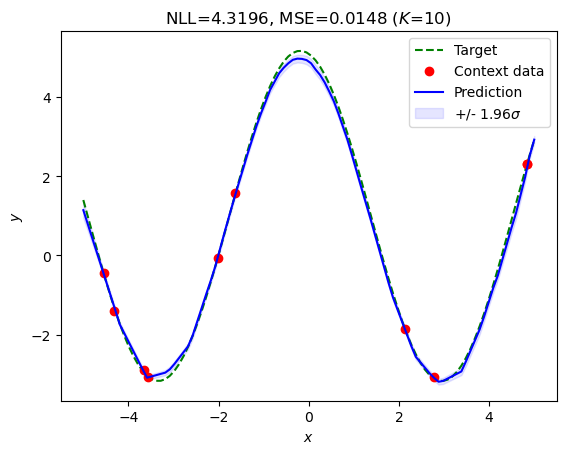

In [144]:
key, subkey = random.split(key)
plots.plot_notebooks_two_kernels(key, kernel1, kernel_self1, kernel2, kernel_self2, jac, output["trained_mean1"], output["trained_mean2"], K=10, task_type="sine")

Most probable kernel is 1


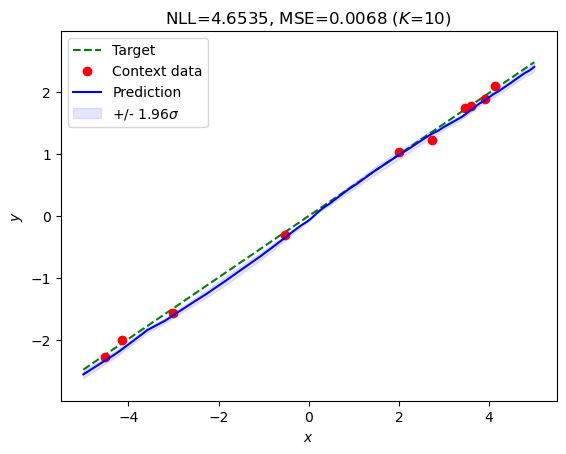

In [145]:
key, subkey = random.split(key)
plots.plot_notebooks_two_kernels(key, kernel1, kernel_self1, kernel2, kernel_self2, jac, output["trained_mean1"], output["trained_mean2"], K=10, task_type="line")